In [1]:
from src.classes.network import Network
from src.classes.node import Node
from src.experimentation import generate_networks, read_and_load_networks, multiple_correlations_par
import src.experimentation
from multiprocessing import Pool
from src.viusalization import plot_cascade_dist, plot_cascade_dist_average
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os, sys
import numpy as np



#### Global Values

In [2]:
correlations = np.linspace(-1, 1, 11)
correlations = np.round(correlations, 1)
initial_seeds = np.linspace(13, 1600, 11)
num_runs = 30
num_nodes = 200
update_fraction = 0.1
average_degree = 8
starting_distribution = 0.5     # L / R ratio (niet per se nodig maar kan misschien leuk zijn om te varieern)
p = average_degree/(num_nodes-1) 
updates = 300000


#### Setting seed for fixed order for sets, for reproducability purposes

In [3]:
# %env PYTHONHASHSEED=134

In [4]:
# def multiple_correlations(corr, start_seed = 39):

#     num_nodes = 200
#     correlation = corr
#     update_fraction = 0.1
#     average_degree = 8
#     starting_distribution = 0.5     # L / R ratio (niet per se nodig maar kan misschien leuk zijn om te varieern)

#     # average degree of 8
#     p = average_degree/(num_nodes-1)
#     seedje = start_seed
#     number_of_experiments = 10
#     collection_of_all_before = defaultdict(list)
#     collection_of_all_after = defaultdict(list)
#     largest_size_of_all = 0
#     save=True


#     def develop_network(num_nodes, correlation, update_fraction, starting_distribution, seedje, p):
#         network = Network(num_nodes, mean=0, correlation=correlation, update_fraction=update_fraction, starting_distribution=starting_distribution, seed=seedje, p=p)

#         number_of_iters=10000
#         data_before, average_data_before = create_data(number_of_iters, network)
#         largest_size = max(data_before.keys())

#         number_of_alterations = 0

        
#         for _ in range(1000000):
#             network.update_round()
#             number_of_alterations += network.alterations
#         print(number_of_alterations)

#         after_data, average_after_data = create_data(number_of_iters, network)
#         if max(after_data.keys()) > largest_size:
#             largest_size = max(after_data.keys())
#         return (data_before, average_data_before), (after_data, average_after_data), largest_size

#     for i in range(number_of_experiments):

#         seedje +=i
#         (before_data, averaged_before_data), (after_data, averaged_after_data), largest_size=develop_network(num_nodes, correlation, update_fraction, starting_distribution, seedje, p)
#         if largest_size > largest_size_of_all:
#             largest_size_of_all = largest_size
#         for size, polarizations in before_data.items():
#             collection_of_all_before[size].extend(polarizations)

#         for size, polarizations in after_data.items():
#             collection_of_all_after[size].extend(polarizations)
        

#     plot_cascade_dist_average(collection_of_all_before, "before", largest_size_of_all, number_of_experiments, save, correlation)
#     plot_cascade_dist_average(collection_of_all_after, "after", largest_size_of_all, number_of_experiments, save, correlation)

#### Developing and saving network

In [5]:

# # dummy values
# num_runs = 10
# updates=10000

# generate_networks(correlations, initial_seeds, num_nodes=num_nodes, iterations=updates, how_many=num_runs, update_fraction=update_fraction, starting_distribution=starting_distribution, p=p)

 #### Reading in and generating Network

In [6]:
# all_networks = read_and_load_networks(num_runs, num_nodes, update_fraction, average_degree, starting_distribution, correlations)


# test = False

# if test:
#     # Test consistency of the networks
#     used_seed = int(initial_seeds[0])
#     test_network = Network("random", num_nodes, mean=0, correlation=-1.0, update_fraction=update_fraction, starting_distribution=starting_distribution, seed=used_seed, p=p)
#     number_of_alterations = 0
#     for _ in range(updates):
#         test_network.update_round()
#         number_of_alterations += test_network.alterations
#         test_network.clean_network()
        
#     assert set([(conn[0].ID, conn[1].ID) for conn in all_networks[(-1.0, 0)][1].connections]) == set([(conn[0].ID, conn[1].ID) for conn in test_network.connections]), "The networks that are generated should be the same"



#### Analyzing and plotting the Cascade distributions

In [7]:
# def create_data(iters, network):

#     all_cascade_sizes = []
#     all_polarizations = []
#     average_cascade_per_round = []
#     average_polarization_per_round = []
#     number_of_samplers = 20

#     for _ in range(iters): 
#         cascades, cascade_dist, cascade_polarization = network.analyze_network()
#         average_cascade_per_round.append(sum(cascade_dist)/number_of_samplers)
#         average_polarization_per_round.append(sum(cascade_polarization))
#         all_cascade_sizes += cascade_dist
#         all_polarizations += cascade_polarization

#         # plot_network(network, cascades)

#     data = defaultdict(list)
#     for i, (size, polarization) in enumerate(zip(all_cascade_sizes, all_polarizations), 1):
#         data[size].append(polarization)
#     for size in data:
#         data[size].sort()

#     average_data = defaultdict(list)
#     for (size, polarization) in zip(average_cascade_per_round, average_polarization_per_round):
#         average_data[size].append(polarization) 
#     for size in average_data: 
#         average_data[size].sort()
        
#     return data, average_data
    

##### Code is working heheheh


starting experimentation for correlation: -1.0
-----------------------------------------------
Starting parallel cascade experiments with correlation -1.0
Finished all cascade experiments for correlation -1.0


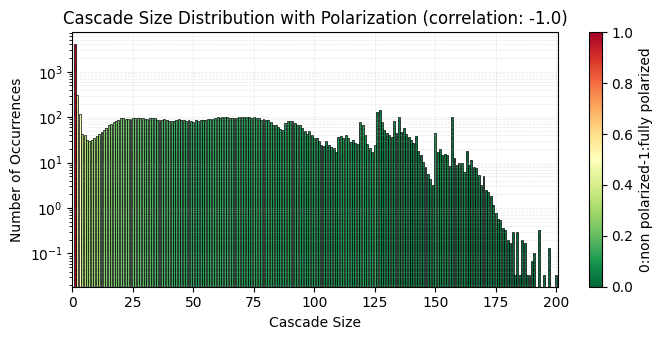

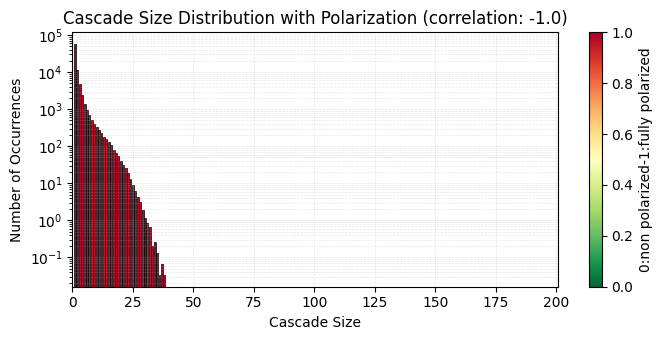

starting experimentation for correlation: -0.8
-----------------------------------------------
Starting parallel cascade experiments with correlation -0.8
Finished all cascade experiments for correlation -0.8


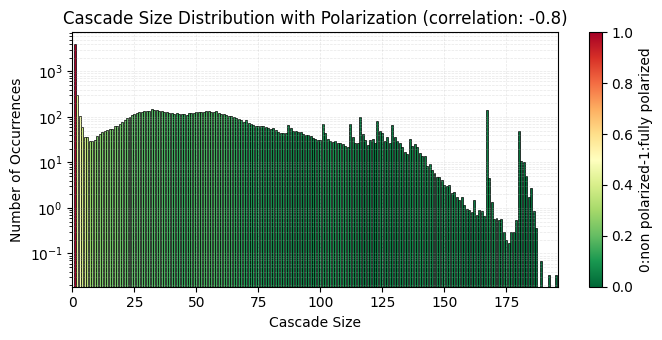

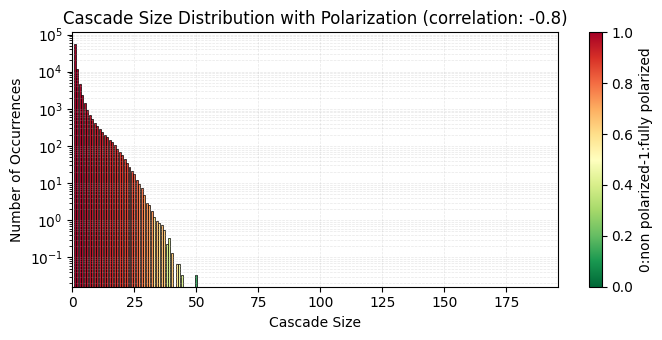

starting experimentation for correlation: -0.6
-----------------------------------------------
Starting parallel cascade experiments with correlation -0.6
Finished all cascade experiments for correlation -0.6


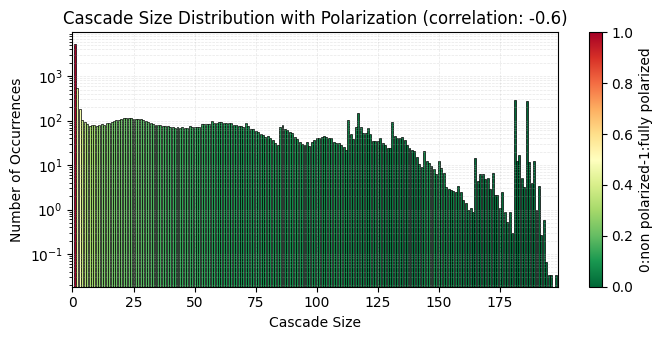

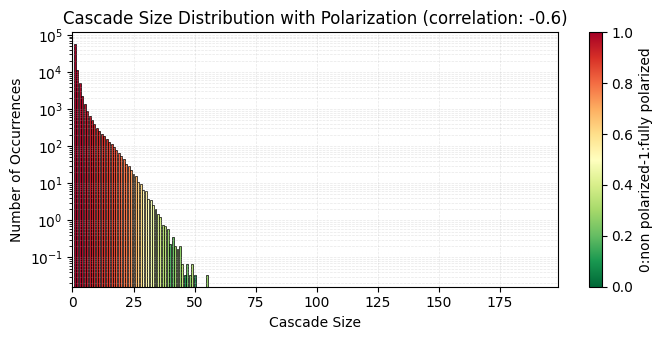

starting experimentation for correlation: -0.4
-----------------------------------------------
Starting parallel cascade experiments with correlation -0.4
Finished all cascade experiments for correlation -0.4


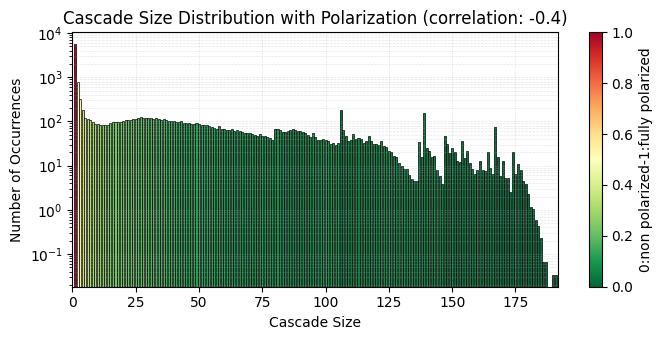

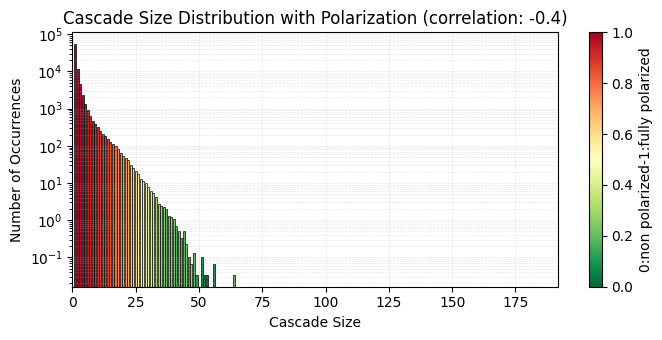

starting experimentation for correlation: -0.2
-----------------------------------------------
Starting parallel cascade experiments with correlation -0.2
Finished all cascade experiments for correlation -0.2


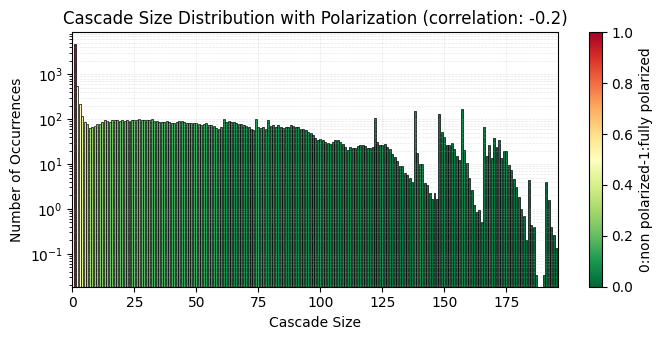

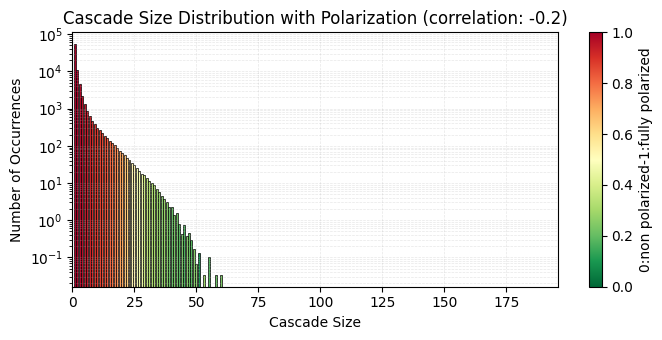

starting experimentation for correlation: 0.0
-----------------------------------------------
Starting parallel cascade experiments with correlation 0.0
Finished all cascade experiments for correlation 0.0


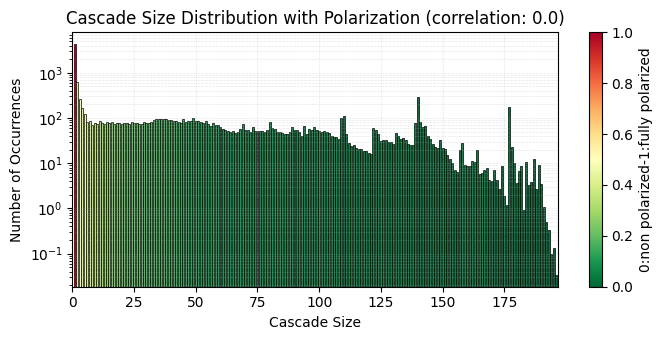

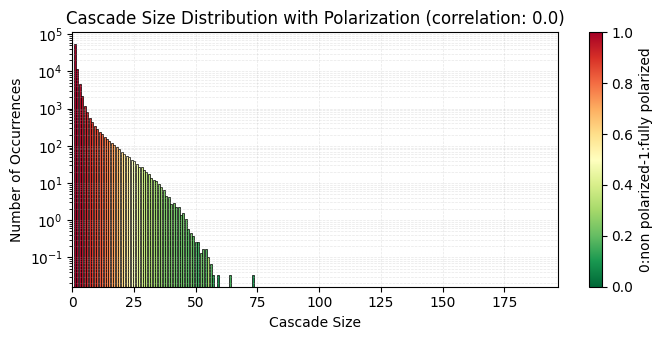

starting experimentation for correlation: 0.2
-----------------------------------------------
Starting parallel cascade experiments with correlation 0.2
Finished all cascade experiments for correlation 0.2


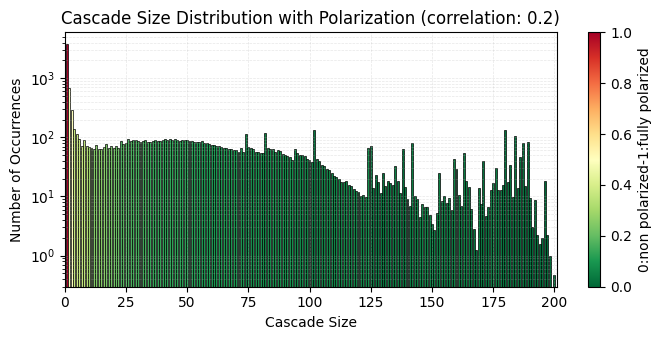

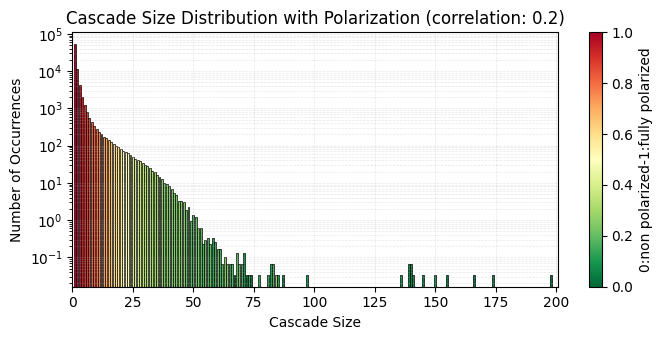

starting experimentation for correlation: 0.4
-----------------------------------------------
Starting parallel cascade experiments with correlation 0.4
Finished all cascade experiments for correlation 0.4


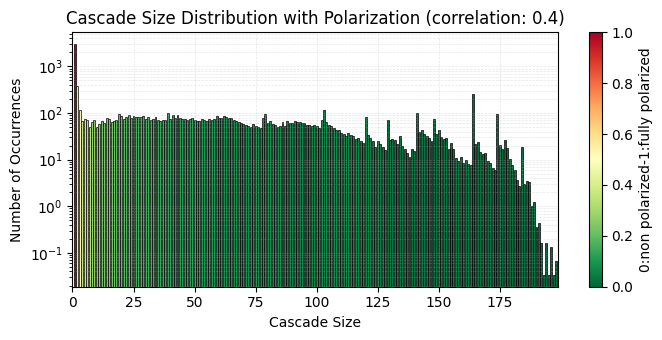

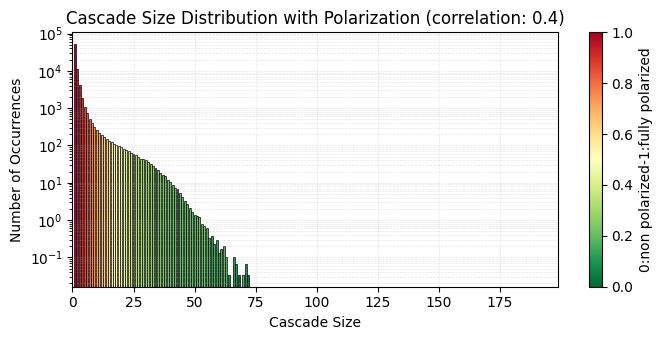

starting experimentation for correlation: 0.6
-----------------------------------------------
Starting parallel cascade experiments with correlation 0.6
Finished all cascade experiments for correlation 0.6


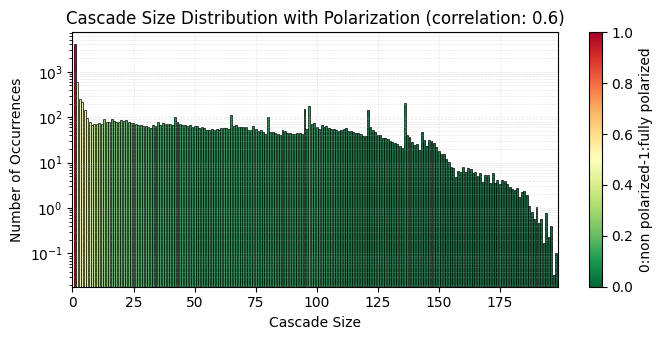

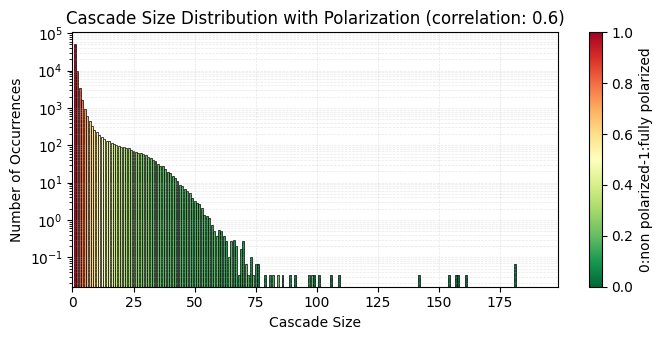

starting experimentation for correlation: 0.8
-----------------------------------------------
Starting parallel cascade experiments with correlation 0.8
Finished all cascade experiments for correlation 0.8


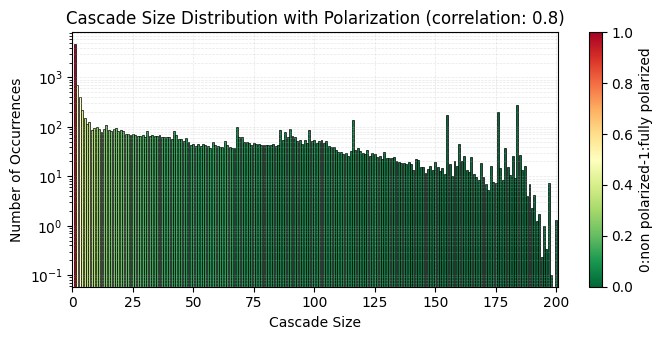

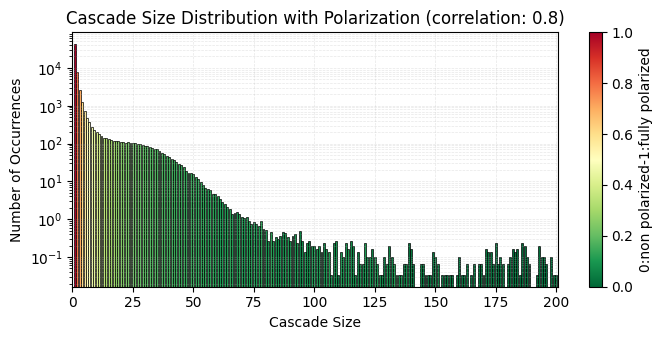

starting experimentation for correlation: 1.0
-----------------------------------------------
Starting parallel cascade experiments with correlation 1.0
Finished all cascade experiments for correlation 1.0


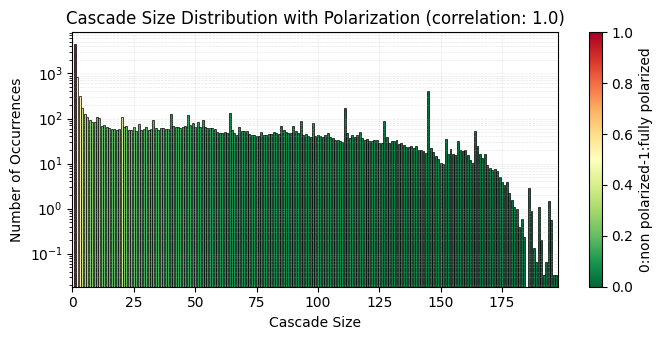

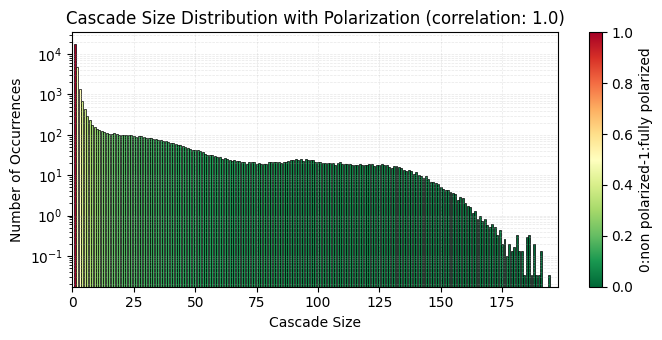

In [8]:
cascades_before = defaultdict(lambda: defaultdict(list))
cascades_after = defaultdict(lambda: defaultdict(list))
save=True
sizes = defaultdict()

for corr in correlations: 
    print(f"starting experimentation for correlation: {corr}")
    print("-----------------------------------------------")

    (before_after, before_after_averaged, largest_sizes) = multiple_correlations_par(corr, num_runs, num_nodes, update_fraction, average_degree, starting_distribution)
    (collection_of_all_before, collection_of_all_after) = before_after
    (coll_of_all_before_averaged, coll_of_all_after_averaged) = before_after_averaged
    (largest_size_of_all, largest_size_of_all_averaged) = largest_sizes
    plot_cascade_dist_average(collection_of_all_before, "before", largest_size_of_all, num_runs, save, corr)
    plot_cascade_dist_average(collection_of_all_after, "after", largest_size_of_all, num_runs, save, corr)
    
    sizes[corr] = largest_size_of_all
    cascades_before[corr] = collection_of_all_before
    cascades_after[corr] = collection_of_all_after


In [31]:
# from matplotlib.animation import FuncAnimation
# import matplotlib.pyplot as plt

# def plot_cascade_animation(cascades, correlations, largest_sizes, num_exp, save=False):
#     """
#     Create an animated visualization of cascade distributions over multiple correlation values.

#     Parameters:
#     -----------
#     cascades : dict
#         Dictionary where keys are correlation values and values are the distribution data.
#     correlations : list
#         List of correlation values to iterate over.
#     largest_sizes : dict
#         Dictionary mapping correlation values to the largest cascade size.
#     num_exp : int
#         Number of experiments for normalization.
#     save : bool, optional
#         If True, saves the animation as a .gif file.
#     """

#     fig, ax = plt.subplots(figsize=(7, 3.5))

#     # **Initialize bar objects**
#     sizes = list(sorted(set(size for data in cascades.values() for size in data.keys())))
#     counts = np.zeros(len(sizes))
#     bars = ax.bar(sizes, counts, color="gray", edgecolor="black", linewidth=0.5)

#     # **Create a fixed colorbar (Do NOT recreate it in every frame)**
#     sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=1))
#     sm.set_array([])
#     cbar = plt.colorbar(sm, ax=ax)
#     cbar.set_label("0: non polarized - 1: fully polarized")

#     def update(frame):
#         """Update function for animation (updates bars but not colorbar)."""
#         ax.clear()

#         corr = correlations[frame]
#         data = cascades[corr]
#         largest_size = largest_sizes[corr]

#         counts = np.zeros(len(sizes))
#         avg_polarizations = np.zeros(len(sizes))

#         sizes = sorted(data.keys())
#         counts = np.array([len(data[size]) / num_exp for size in sizes], dtype=np.float64)
#         avg_polarizations = np.array([np.mean(np.abs(data[size])) for size in sizes])

#         # **If it's the first frame, create the bars**
#         if bars is None:
#             bars = ax.bar(sizes, counts, color=[plt.cm.RdYlGn_r(p) for p in avg_polarizations],
#                           edgecolor="black", linewidth=0.5)
#         else:
#             # **Update bar heights and colors**
#             for bar, count, color_value in zip(bars, counts, avg_polarizations):
#                 bar.set_height(count)
#                 bar.set_color(plt.cm.RdYlGn_r(color_value))
#                 bar.set_edgecolor("black")  # Retain black borders
            

#         # Update title and axes
#         ax.set_title(f"Cascade Size Distribution (Correlation: {corr})")
#         ax.set_xlim(0, largest_size)
#         ax.set_yscale("log")
#         ax.set_ylim(1, max(counts) * 1.2 if max(counts) > 0 else 10)  # Adjust dynamically
#         ax.set_xlabel("Cascade Size")
#         ax.set_ylabel("Number of Occurrences")

#         ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.3)

#     # Create animation
#     ani = FuncAnimation(fig, update, frames=len(correlations), repeat=False)

#     # Save or display animation
#     if save:
#         ani.save("cascade_distribution_animation.gif", writer="ffmpeg", fps=1, dpi=300)
#     else:
#         plt.show()



In [45]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np

def plot_cascade_animation(cascades, correlations, largest_sizes, num_exp, save=False, stage="before"):
    """
    Create an animated visualization of cascade distributions over multiple correlation values.

    Parameters:
    -----------
    cascades : dict
        Dictionary where keys are correlation values and values are the distribution data.
    correlations : list
        List of correlation values to iterate over.
    largest_sizes : dict
        Dictionary mapping correlation values to the largest cascade size.
    num_exp : int
        Number of experiments for normalization.
    save : bool, optional
        If True, saves the animation as a .gif file.
    """

    fig, ax = plt.subplots(figsize=(7, 3.5))

    # **Initialize bar objects**
    sizes = list(sorted(set(size for data in cascades.values() for size in data.keys())))
    initial_counts = np.zeros(len(sizes))
    bars = ax.bar(sizes, initial_counts, color="gray", edgecolor="black", linewidth=0.5)

    # **Create a fixed colorbar (Do NOT recreate it in every frame)**
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("0: non polarized - 1: fully polarized")

    def update(frame):
        """Update function for animation (updates bars but not colorbar)."""
        corr = correlations[frame]
        data = cascades[corr]
        largest_size = largest_sizes[corr]

        counts = np.zeros(len(sizes))
        avg_polarizations = np.zeros(len(sizes))

        # Process data for this frame
        for i, size in enumerate(sizes):
            if size in data:
                values = data[size]
                counts[i] = len(values) / num_exp  # Normalize counts
                avg_polarizations[i] = np.mean(np.abs(values))  # Average polarization

        # **Update bar heights and colors instead of recreating bars**
        for bar, count, color_value in zip(bars, counts, avg_polarizations):
            bar.set_height(count)
            bar.set_color(plt.cm.RdYlGn_r(color_value))  # Update color
            bar.set_edgecolor("black")

        ax.set_title(f"Cascade Size Distribution (Correlation: {corr})")
        ax.set_xlim(0, largest_size)
        ax.set_yscale("log")
        if stage == "after":
            ax.set_ylim(10e-3, 10e4)
        else: 
            ax.set_ylim(10e-3, 10e3)

    # Create animation
    ani = FuncAnimation(fig, update, frames=len(correlations), repeat=False)

    # Save or display animation
    if save:
        ani.save(f"cascade_distribution_animation_{stage}.gif", writer="ffmpeg", fps=1.5, dpi=300)
    else:
        plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\chris\AppData\Local\Temp\ipykernel_27620\1582281608.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
MovieWriter ffmpeg unavailable; using Pillow instead.
C:\Users\chris\AppData\Local\Temp\ipykernel_27620\1582281608.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


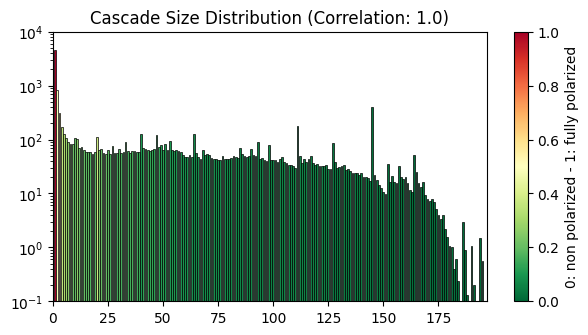

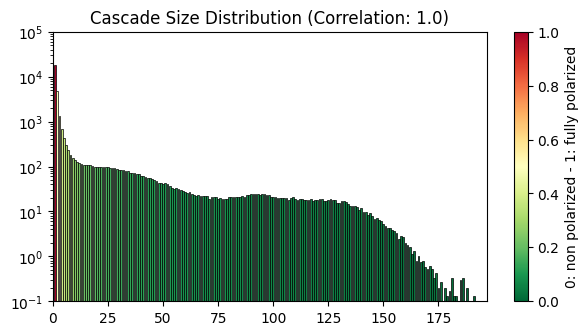

In [46]:
plot_cascade_animation(cascades_before, list(reversed(correlations)), sizes, num_runs, save=True, stage="before")
plot_cascade_animation(cascades_after, list(reversed(correlations)), sizes, num_runs, save=True, stage="after")

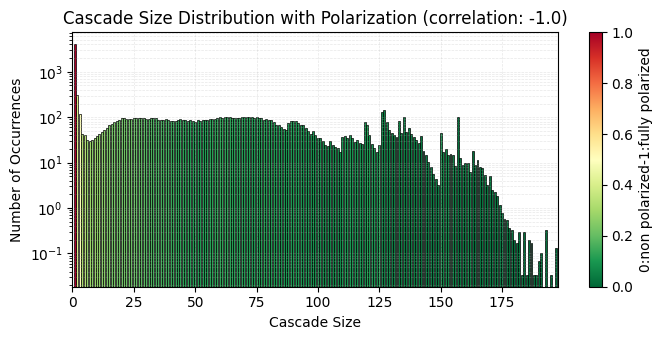

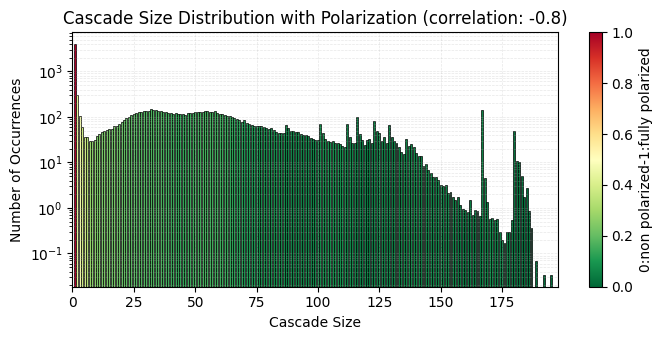

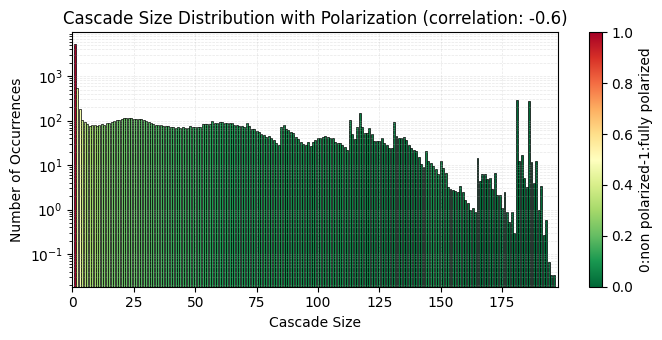

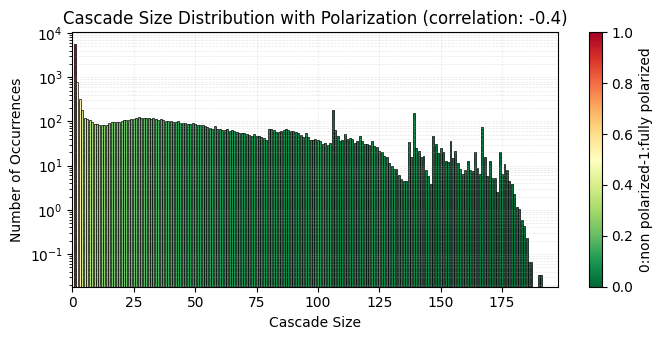

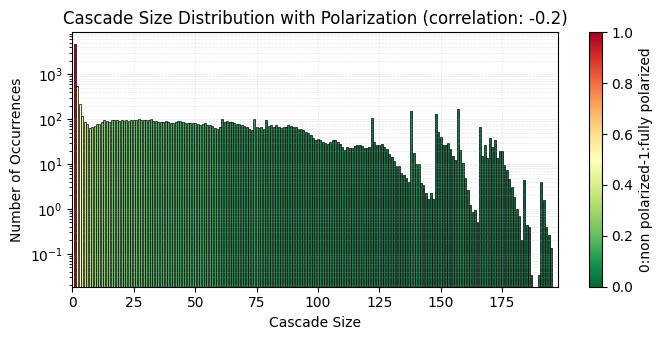

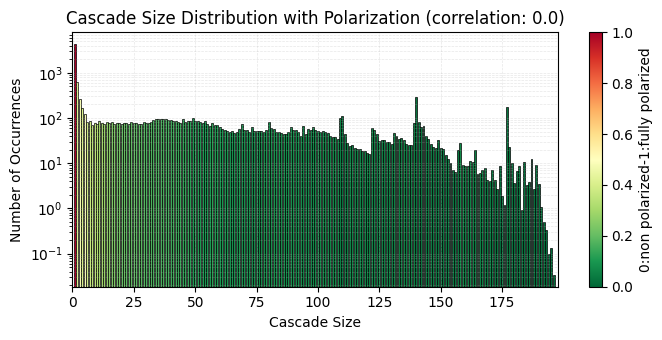

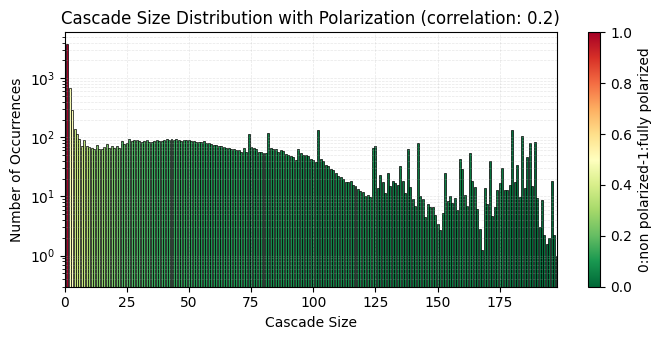

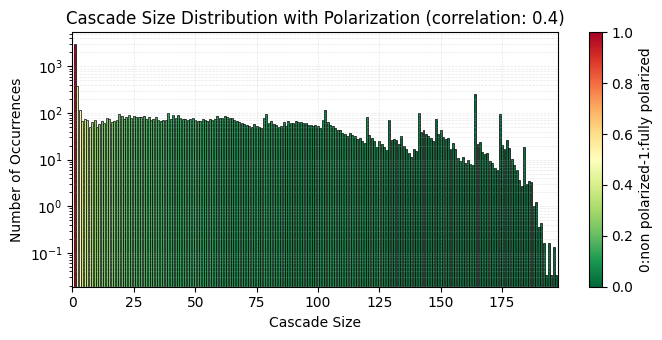

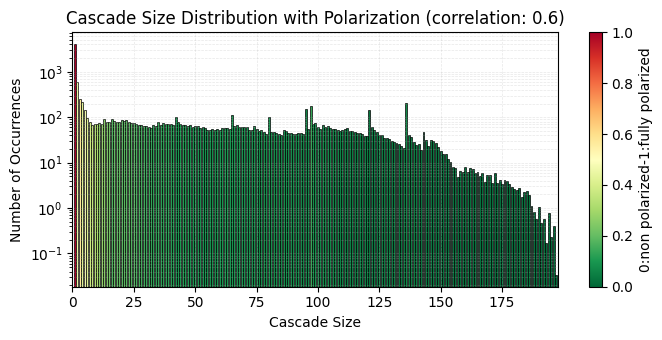

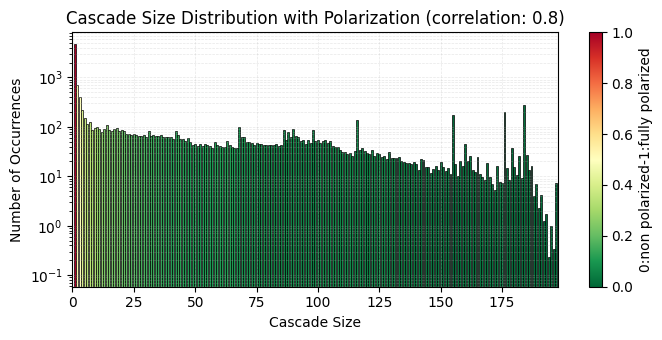

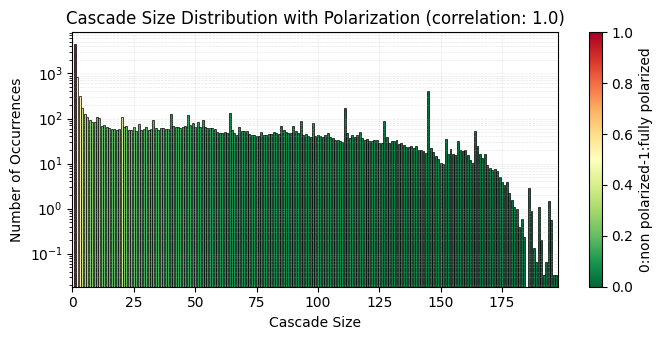

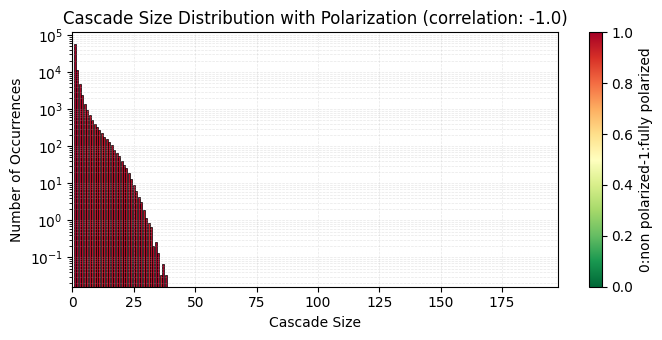

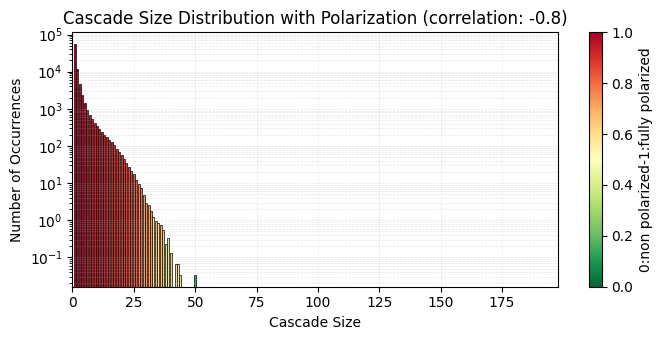

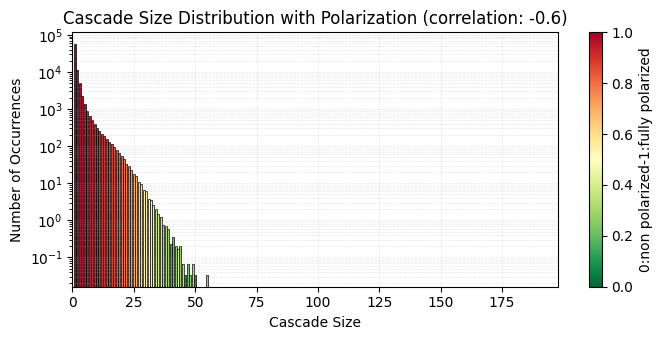

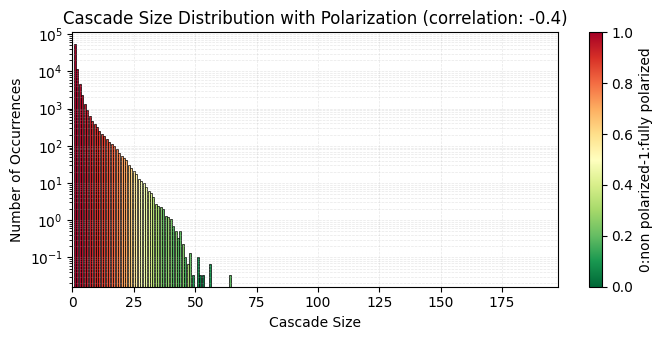

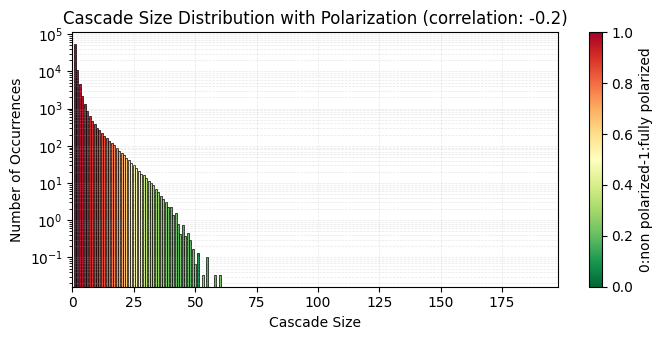

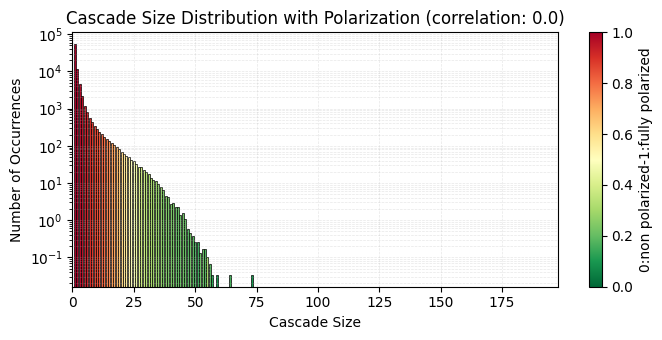

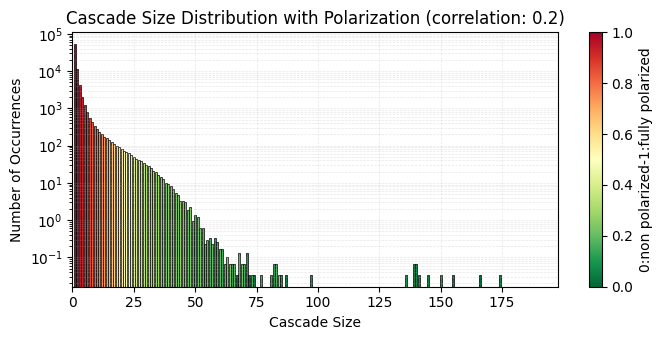

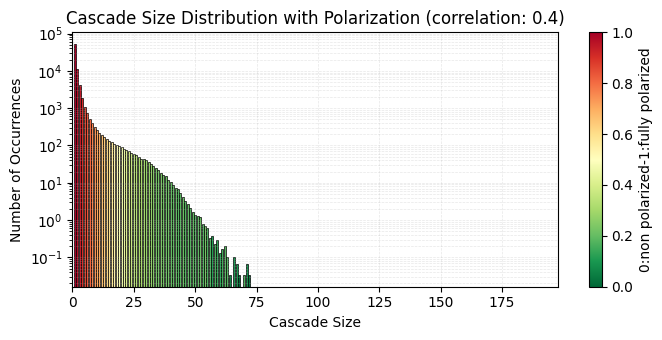

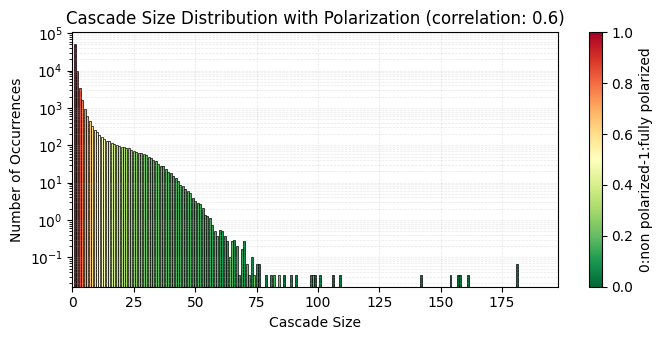

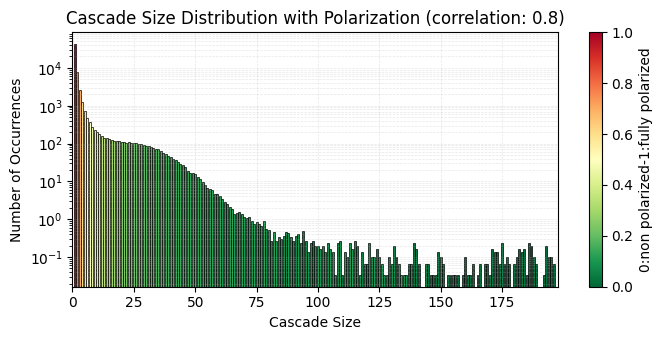

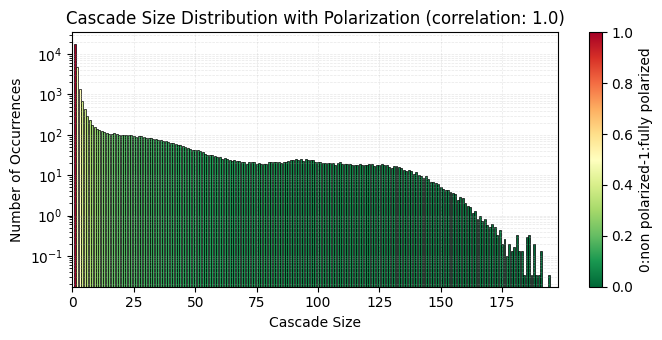

In [10]:
for key,value in cascades_before.items():
    plot_cascade_dist_average(value, "before", largest_size_of_all, num_runs, save, key)

for key,value in cascades_after.items():
    plot_cascade_dist_average(value, "after", largest_size_of_all, num_runs, save, key)

cascades_before[corr] = collection_of_all_before
cascades_after[corr] = collection_of_all_after